In [1]:
import keras
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import to_categorical
from keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,BatchNormalization,GlobalAveragePooling2D,UpSampling2D

from keras.models import Model,load_model
from keras.datasets import cifar100
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau

from keras.applications import ResNet50V2


In [2]:
(x_train, y_train), (x_test, y_test)=cifar100.load_data()
print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 1)


(10000, 32, 32, 3)
(50000, 100)


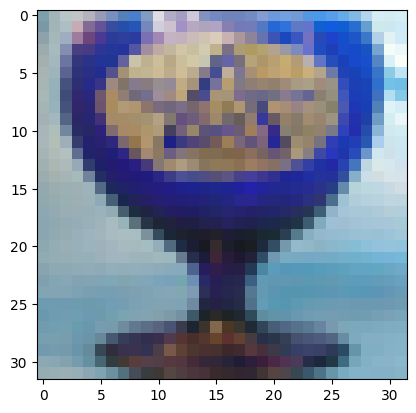

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [3]:
x_train = x_train*1.0/255
x_test = x_test*1.0/255

y_train=to_categorical(y_train, num_classes=100)
y_test=to_categorical(y_test, num_classes=100)

print(x_test.shape)
print(y_train.shape)
plt.imshow(x_train[15802]) # my dob
plt.show()
print(y_train[15802])

In [4]:
train_datagen = image.ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    horizontal_flip = True,
    vertical_flip = False
    )
train_datagen.fit(x_train)

In [5]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.6,
    min_lr=1e-6)


In [6]:
resnet = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

In [7]:
iem=keras.models.Sequential(name='ResNet50-for-Cifar100')

iem.add(UpSampling2D(size=(7, 7),interpolation='bilinear'))
iem.add(resnet)
iem.add(GlobalAveragePooling2D())
iem.add(Dropout(0.25))
iem.add(Dense(256, activation='relu'))
iem.add(BatchNormalization())
iem.add(Dense(100, activation='softmax'))
iem.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),loss='categorical_crossentropy',metrics=['accuracy'])
iem.build(input_shape=(None, 224, 224, 3))
iem.summary()

Model: "ResNet50-for-Cifar100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2  (None, 1568, 1568, 3)     0         
 D)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization (Batch  (None, 256)     

In [8]:
model=iem.fit(x_train, y_train, validation_split=0.2, epochs = 5, verbose = 1, callbacks = [learning_rate_reduction])

Epoch 1/5
1250/1250 [==============================] - 317s 233ms/step - loss: 2.6474 - accuracy: 0.3688 - val_loss: 1.5980 - val_accuracy: 0.5606 - lr: 0.0010
Epoch 2/5
1250/1250 [==============================] - 291s 233ms/step - loss: 1.5723 - accuracy: 0.5736 - val_loss: 1.3059 - val_accuracy: 0.6289 - lr: 0.0010
Epoch 3/5
1250/1250 [==============================] - 292s 233ms/step - loss: 1.3161 - accuracy: 0.6302 - val_loss: 1.1646 - val_accuracy: 0.6642 - lr: 0.0010
Epoch 4/5
1250/1250 [==============================] - 277s 222ms/step - loss: 1.1733 - accuracy: 0.6633 - val_loss: 1.0851 - val_accuracy: 0.6829 - lr: 0.0010
Epoch 5/5
1250/1250 [==============================] - 291s 233ms/step - loss: 1.0723 - accuracy: 0.6892 - val_loss: 1.0255 - val_accuracy: 0.6973 - lr: 0.0010


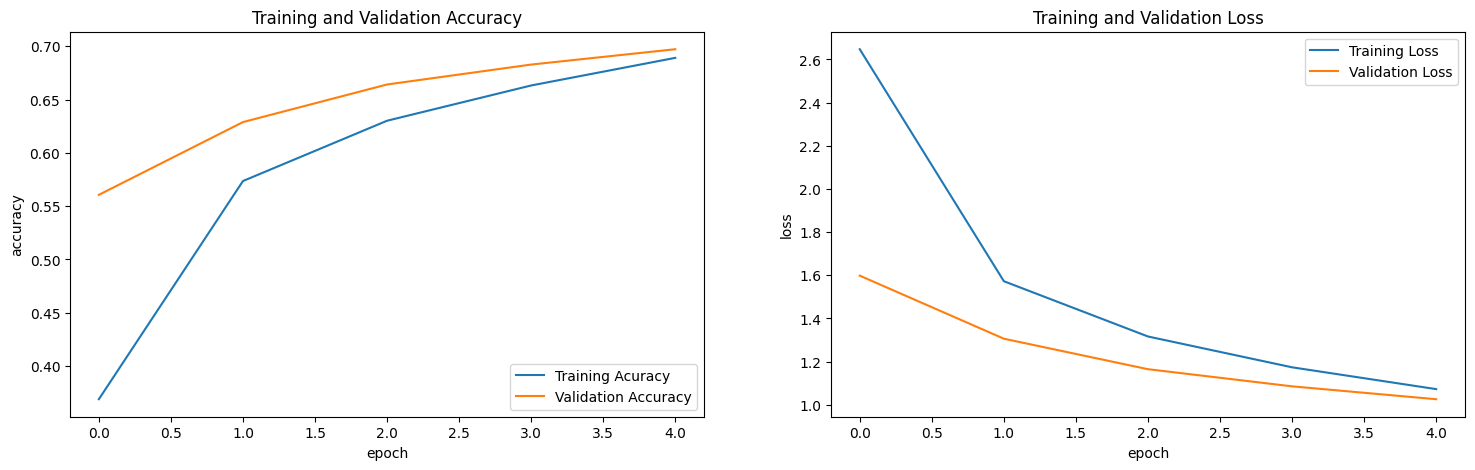

In [9]:
acc = model.history['accuracy']
val_acc = model.history['val_accuracy']
loss = model.history['loss']
val_loss = model.history['val_loss']

plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.title("Training and Validation Accuracy")
plt.plot(acc,label = 'Training Acuracy')
plt.plot(val_acc,label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.title('Training and Validation Loss')
plt.plot(loss,label = 'Training Loss')
plt.plot(val_loss,label = 'Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')

plt.show()


In [10]:
iem.evaluate(x_test,y_test)

313/313 [==============================] - 28s 91ms/step - loss: 0.9952 - accuracy: 0.7034


[0.9951640367507935, 0.7034000158309937]